# Notebook for checking JAX implementation of SIS Algo

In [11]:
import jax
import jax.numpy as jnp
from jax import lax
import jax.random as random
import numpy as np
from jax import jit
from jax import vmap
from functools import partial
import jax.numpy as jnp
import jax.random as random
import jax
from functools import partial
from jax import vmap, lax, random, jit
import jax.numpy as jnp

## Checks for SIS Algo implementation

In [12]:
num_states = 3
num_emissions = 4
seq_length = 51
seed = 1

# Generate random HMM parameters
key = random.PRNGKey(seed)
trans_mat = random.dirichlet(key, jnp.ones(num_states), shape=(num_states,))
emission_mat = random.dirichlet(key, jnp.ones(num_emissions), shape=(num_states,))

# Generate synthetic observation data
key, subkey = random.split(key)
init_probs = jnp.array([1/num_states for _ in range(num_states)])

# Initialize true_hidden_states with the first state using the init_probs
key, subkey = random.split(key)
first_state = random.choice(subkey, num_states, p=init_probs)
true_hidden_states = [first_state]

# Generate the rest of the true hidden states using the transition matrix
for _ in range(seq_length - 1):
    key, subkey = random.split(key)
    current_state = random.choice(subkey, num_states, p=trans_mat[true_hidden_states[-1]])
    true_hidden_states.append(current_state)

true_hidden_states = jnp.array(true_hidden_states)

key, *subkeys = random.split(key, 1+seq_length)
obs_data = jnp.array([random.choice(k, num_emissions, p=emission_mat[state]) for k, state in zip(subkeys, true_hidden_states)])

In [13]:
import itertools
import jax.numpy as jnp
from jax.scipy.special import expit

num_bins = 3
bin_weight_prior_par = jnp.array([1.0 for _ in range(num_bins)])

# Generate all possible sequences of length 3 with elements in the range [0, num_bins)
sequences = list(itertools.product(range(num_bins), repeat=3))

log_evidences = []
for seq in sequences:
    obs = jnp.array(seq)
    log_evidence = baseline_log_evidence_hmm(obs, num_bins, bin_weight_prior_par)
    log_evidences.append(log_evidence)

# Convert log_evidences to probabilities
evidences = jax.scipy.special.logsumexp(jnp.array(log_evidences))
total_probability = jnp.exp(evidences)

print(f"Total probability: {total_probability:.10f}")


Total probability: 1.0000016689


In [38]:
sis_out = sis_estimator_hmm(obs=obs_data,
                        num_bins=4,
                        iters=3,
                        num_hidden_states=3,
                        single_bin_weight_prior=1.,
                        single_latent_weight_prior=1.,
                        seed=0)

hello, doing a sis iter!
On iter 1


TypeError: reshape total size must be unchanged, got new_sizes (1,) for shape (1, 0, 0).

In [7]:
obs = obs_data
num_bins = 4
iters = 2
num_hidden_states = 3
single_bin_weight_prior = 1.
single_latent_weight_prior = 1.
seed = 0

In [10]:
bin_weight_prior_par = jnp.repeat(single_bin_weight_prior,num_bins)
latent_prior_par = jnp.repeat(single_latent_weight_prior,num_hidden_states)
num_obs = obs.shape[0]

In [13]:
key = random.PRNGKey(seed)

In [16]:
latents = jnp.zeros(num_obs, dtype=jnp.float32)
latents = latents.at[0].set(random.categorical(key, logits=jnp.log(latent_prior_par)))
init_log_evidence_weight = baseline_log_evidence_hmm(obs[0:1], num_bins, bin_weight_prior_par)

In [24]:
*_, log_evidence_weight = val

In [31]:
%%timeit
val = (key, latents, init_log_evidence_weight)
for i in range(1, num_obs):
    val = loop_body(i, val)

4.17 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(1, 2)

In [26]:
obs_data[0].reshape(len(obs_data[0]))

TypeError: len() of unsized object

In [39]:
def sis_estimator_hmm(obs,
                      num_bins,
                      iters,
                      num_hidden_states,
                      single_bin_weight_prior=1.,
                      single_latent_weight_prior=1.,
                      seed=0):
    def loop_body(data_idx, prev_val): # iterate over data_idx
        key, latents, log_evidence_weights = prev_val
        def log_gamma_for_state(state):
            return log_gamma_coefficient_hmm_batched(data_idx, state, obs, latents[:data_idx],
                                                num_bins, num_hidden_states, bin_weight_prior_par,
                                                latent_prior_par)

        # Use vmap to compute log_gamma for all states in parallel
        log_gamma = vmap(log_gamma_for_state)(jnp.arange(num_hidden_states))
        #log_gamma = jnp.array([log_gamma_for_state(state) for state in range(num_hidden_states)])
        
        key, subkey = random.split(key)
        new_latent = random.categorical(key=subkey, logits=log_gamma)
        new_latents = latents.at[data_idx].set(new_latent)
        new_log_evidence_weights = log_evidence_weights + jax.scipy.special.logsumexp(log_gamma)
        return (key, new_latents, new_log_evidence_weights) # val for next iter

    bin_weight_prior_par = jnp.repeat(single_bin_weight_prior,num_bins)
    latent_prior_par = jnp.repeat(single_latent_weight_prior,num_hidden_states)
    num_obs = obs.shape[0]

    def single_sis_iter(key): # Single iteration over which to vmap
        print("hello, doing a sis iter!")
        latents = jnp.zeros(num_obs, dtype=jnp.float32)
        latents = latents.at[0].set(random.categorical(key, logits=jnp.log(latent_prior_par)))

        # obs[0:1] is the first observation, as a 1x1 array
        init_log_evidence_weight = baseline_log_evidence_hmm(obs[0:1], num_bins, bin_weight_prior_par)

        # init_val = (key, latents, init_log_evidence_weight)
        # *_, log_evidence_weight = lax.fori_loop(lower=1, upper=num_obs, body_fun=loop_body, init_val=init_val)
        val = (key, latents, init_log_evidence_weight)
        for i in range(1, num_obs):
            print(f"On iter {i}")
            val = loop_body(i, val)
        *_, log_evidence_weight = val
        return log_evidence_weight

    key = random.PRNGKey(seed)
    keys = random.split(key, iters)
    #log_evidence_weights = vmap(single_sis_iter)(keys)
    log_evidence_weights = jnp.array([single_sis_iter(key) for key in keys])
    return {'evidence': log_evidence_weights }



def log_gamma_coefficient_hmm(idx, state, obs, latents, num_bins, num_states, bin_weight_prior_par, latent_prior_par):
    state_filter = lax.dynamic_slice(latents, (0,), (idx - 1,)) == state
    obs_up_to_idx = lax.dynamic_slice(obs, (0,), (idx - 1,))
    
    # Get the indices where state_filter is True
    # indices = jnp.nonzero()[0]
    prev_state_obs = obs_up_to_idx[state_filter] # Prev. obs associated to given state
    
    new_state_obs = jnp.concatenate([prev_state_obs, jnp.array([obs[idx]])]) # Include new obs in state to calc prob.

    log_evidence_new = baseline_log_evidence_hmm(new_state_obs, num_bins, bin_weight_prior_par)
    log_evidence_prev = baseline_log_evidence_hmm(prev_state_obs, num_bins, bin_weight_prior_par)
    log_posterior_latent_weight = jnp.log(
        post_latent_weight_hmm(state, latents[:idx-1], num_states, latent_prior_par, start_state=latents[idx-1])
        )
    log_evidence_ratio = log_evidence_new - log_evidence_prev # Ratio of m(C_k)) quantities in Hairault et al.

    return log_evidence_ratio + log_posterior_latent_weight # log gamma_k in Hairault et al.


def baseline_log_evidence_hmm(obs, num_bins, bin_weight_prior_par):
    """
    Calculate the "baseline log evidence" for an HMM.
    For given observations, calculates the joint likelihood of these given a shared latent state.
    Amounts to taking the log ratio of posterior and prior normalising constants.

    Args:
        obs (jnp.ndarray): Observations.
        num_bins (int): Number of bins.
        bin_weight_prior_par (float): Bin weight prior parameter.

    Returns:
        float: Log evidence.
    """
    if obs.shape[0] == 0:
        return 0
    
    bin_counts = jnp.bincount(obs, length=num_bins)
    bin_weight_posterior_par = bin_weight_prior_par + bin_counts
    # log_evidence = (jnp.sum(lax.lgamma(bin_weight_posterior_par)) - lax.lgamma(jnp.sum(bin_weight_posterior_par))
    #                 + lax.lgamma(jnp.sum(bin_weight_prior_par)) - jnp.sum(lax.lgamma(bin_weight_prior_par))
    #                 )
    log_prior_normalization = lax.lgamma(jnp.sum(bin_weight_prior_par)) - jnp.sum(lax.lgamma(bin_weight_prior_par))
    log_posterior_normalization = (lax.lgamma(jnp.sum(bin_weight_posterior_par)) - jnp.sum(lax.lgamma(bin_weight_posterior_par)))

    log_evidence = log_prior_normalization - log_posterior_normalization
    return log_evidence

def post_latent_weight_hmm(state, latents, num_states, latent_prior_par, start_state):
    """
    Calculate the posterior latent weight for an HMM.

    Args:
        state (int): State index.
        latents (jnp.ndarray): Latent states.
        num_states (int): Number of states.
        latent_prior_par (float): Latent prior parameter.
        start_state (int): Start state index.

    Returns:
        float: Posterior latent weight.
    """ 
    transition_counts_from_start_state = transition_count(latent_states=latents, num_states=num_states)[jnp.int32(start_state),]
    latent_post_par = latent_prior_par + transition_counts_from_start_state
    return latent_post_par[state] / jnp.sum(latent_post_par)

def transition_count(latent_states, num_states):
    transition_count_mat = jnp.array([
    jnp.bincount(jnp.int32( latent_states[:-1] * num_states + latent_states[1:] ),
                 length=num_states * num_states)]).reshape(num_states, num_states)
    return transition_count_mat


In [116]:
jnp.int32(jnp.array([1.,1.]))

Array([1, 1], dtype=int32)

## Checks for forward/backward implementation

In [18]:
num_states = 3
num_emissions = 4
seq_length = 50
seed = 0

# Generate random HMM parameters
key = random.PRNGKey(seed)
trans_mat = random.dirichlet(key, jnp.ones(num_states), shape=(num_states,))
emission_mat = random.dirichlet(key, jnp.ones(num_emissions), shape=(num_states,))

In [19]:
true_hidden_states

Array([0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       2, 0, 1, 2, 0, 0], dtype=int32)

In [20]:
# Generate synthetic observation data
key, subkey = random.split(key)
init_probs = jnp.array([0.5, 0.3, 0.2])
true_hidden_states = random.choice(subkey, num_states, shape=(seq_length,), p=init_probs)
key, subkey = random.split(key)
obs_data = jnp.array([random.choice(subkey, num_emissions, p=emission_mat[state]) for state in true_hidden_states])

In [21]:
emission_mat

Array([[0.23019393, 0.5227494 , 0.04843829, 0.1986184 ],
       [0.14872883, 0.0815069 , 0.25957426, 0.51019007],
       [0.39489356, 0.32623452, 0.13250461, 0.1463673 ]], dtype=float32)

In [22]:
# Test forward_backward
forward, backward, log_likelihood = forward_backward(obs_data, trans_mat, compute_emission_probs_multinomial, {'emission_mat': emission_mat})

In [21]:
# Test conditional_probability
cond_prob = conditional_probability(obs_data=obs_data, trans_mat=trans_mat,
emission_func=compute_emission_probs_multinomial,
emission_kwargs={'emission_mat': emission_mat},
forward=forward, backward=backward)


In [22]:
cond_prob.shape

(50, 3)

In [23]:
# Test joint_conditional_probabilities
joint_cond_probs = joint_conditional_probabilities(obs_data, trans_mat, compute_emission_probs_multinomial,
    {'emission_mat': emission_mat}, cond_prob_kwargs={'forward': forward, 'backward': backward})


In [28]:
# Print the results
print("Log Likelihood:", log_likelihood)
print("Forward Probabilities:\n", forward)
print("Backward Probabilities:\n", backward)
print("Conditional Probabilities:\n", cond_prob)
print("Joint Conditional Probabilities:\n", joint_cond_probs)

Log Likelihood: -67.19659
Forward Probabilities:
 [[0.3385512  0.03670331 0.6247455 ]
 [0.26476085 0.03221375 0.70302546]
 [0.23468333 0.03522706 0.7300896 ]
 [0.22729062 0.0364662  0.7362432 ]
 [0.2259966  0.0367706  0.73723286]
 [0.22586407 0.0368235  0.73731244]
 [0.22587393 0.0368288  0.7372973 ]
 [0.22588317 0.03682836 0.7372885 ]
 [0.22588599 0.03682797 0.737286  ]
 [0.22588657 0.03682785 0.73728555]
 [0.22588664 0.03682784 0.7372855 ]
 [0.04782274 0.2679736  0.6842037 ]
 [0.40294024 0.04281935 0.55424047]
 [0.12822716 0.05395585 0.81781703]
 [0.08577614 0.06950466 0.8447192 ]
 [0.04260741 0.29641092 0.6609817 ]
 [0.42838773 0.04282741 0.52878475]
 [0.3004478  0.02870283 0.6708494 ]
 [0.24340199 0.03377682 0.72282124]
 [0.04877004 0.26450232 0.68672764]
 [0.18959354 0.08409694 0.7263096 ]
 [0.05687364 0.28254962 0.6605768 ]
 [0.0990739  0.3437101  0.55721605]
 [0.1235863  0.35086668 0.525547  ]
 [0.49989295 0.03924197 0.46086508]
 [0.31945863 0.02603305 0.65450835]
 [0.2471546  0

## Checks for binned MCMC implementation

### Improvement of for loops

In [42]:
import jax.numpy as jnp

# Example hidden states and observations
hidden_states = jnp.array([0, 1, 0, 2, 1, 0, 1, 2, 2, 1])
observations = jnp.array([1, 3, 0, 2, 3, 1, 3, 2, 2, 1])

n_states = 3
n_bins = 4

# Transition matrix update
# Explicit for loop
trans_mat_loop = jnp.zeros((n_states, n_states))
for i in range(len(hidden_states) - 1):
    trans_mat_loop = trans_mat_loop.at[hidden_states[i], hidden_states[i + 1]].add(1)

# Vectorized update
aux_trans_mat = jnp.array([
    jnp.bincount(hidden_states[:-1] * n_states + hidden_states[1:], minlength=n_states * n_states)
]).reshape(n_states, n_states)

print("Transition matrix update")
print("Explicit loop:", trans_mat_loop)
print("Vectorized:", aux_trans_mat)

# Emission matrix update
# Explicit for loop
emission_mat_loop = jnp.zeros((n_states, n_bins))
for i in range(len(hidden_states)):
    emission_mat_loop = emission_mat_loop.at[hidden_states[i], observations[i]].add(1)

# Vectorized update
aux_emission_mat = jnp.zeros((n_states, n_bins))
for j in range(n_bins):
    count = jnp.sum((observations[:, None] == j) & (hidden_states[:, None] == jnp.arange(n_states)[None, :]), axis=0)
    aux_emission_mat = aux_emission_mat.at[:, j].set(count)

def emission_auxiliary_matrix_vectorized_no_bin_loop(states, observations, num_states, num_bins):
    state_idx = jnp.arange(num_states)[:, None, None]
    print(f"state_idx: {state_idx}")
    obs_idx = jnp.array(observations)[None, :]
    print(f"obs_idx: {obs_idx}")

    matches = (state_idx == jnp.array(states)[None, :])
    bin_matches = (jnp.arange(num_bins)[:, None] == obs_idx)

    return jnp.sum(matches & bin_matches[None, :, :], axis=-1)

emission_mat_vectorized_no_bin_loop = emission_auxiliary_matrix_vectorized_no_bin_loop(hidden_states, observations, 3, 4)

print("Emission matrix update")
print("Explicit loop:", emission_mat_loop)
print("Vectorized:", aux_emission_mat)
print("Vectorized without bin loop:", emission_mat_vectorized_no_bin_loop)

Transition matrix update
Explicit loop: [[0. 2. 1.]
 [2. 0. 1.]
 [0. 2. 1.]]
Vectorized: [[0 2 1]
 [2 0 1]
 [0 2 1]]
state_idx: [[[0]]

 [[1]]

 [[2]]]
obs_idx: [[1 3 0 2 3 1 3 2 2 1]]
Emission matrix update
Explicit loop: [[1. 2. 0. 0.]
 [0. 1. 0. 3.]
 [0. 0. 3. 0.]]
Vectorized: [[1. 2. 0. 0.]
 [0. 1. 0. 3.]
 [0. 0. 3. 0.]]
Vectorized without bin loop: [[1 2 0 0]
 [0 1 0 3]
 [0 0 3 0]]


### Checks on the Gibbs sampler

In [1]:
import jax
import jax.numpy as jnp
from jax import lax
import jax.random as random
import numpy as np
from jax import jit
from jax import vmap
from functools import partial
import time

In [2]:
%run hmm_helpers.py
%run hmm_mcmc.py

In [20]:
# Parameters for testing
num_states = 20
num_emissions = 4
num_bins = 4
seq_length = 2000
seed = 0

# Generate random HMM parameters
key = random.PRNGKey(seed)
trans_mat = random.dirichlet(key, jnp.ones(num_states), shape=(num_states,))
emission_mat = random.dirichlet(key, jnp.ones(num_emissions), shape=(num_states,))

# Generate synthetic observation data
key, subkey = random.split(key)
init_probs = jnp.array([1/num_states for _ in range(num_states)])

# Initialize true_hidden_states with the first state using the init_probs
key, subkey = random.split(key)
first_state = random.choice(subkey, num_states, p=init_probs)
true_hidden_states = [first_state]

# Generate the rest of the true hidden states using the transition matrix
for _ in range(seq_length - 1):
    key, subkey = random.split(key)
    current_state = random.choice(subkey, num_states, p=trans_mat[true_hidden_states[-1]])
    true_hidden_states.append(current_state)

true_hidden_states = jnp.array(true_hidden_states)

key, *subkeys = random.split(key, 1+seq_length)
obs_data = jnp.array([random.choice(k, num_emissions, p=emission_mat[state]) for k, state in zip(subkeys, true_hidden_states)])

In [24]:
num_its = 1000

In [25]:
# Run the Gibbs sampler
gibbs_results = binned_prior_sampler(obs_data, num_states, num_bins, num_its, seed=seed) # 144s on 2k iters, 2k obs, 2 states, 4 bins

### Checking the other samplers

When num_states is large, we find a bottleneck in sample_trans_mat. We fix it by making sure the prior is of type float32 rather than int32, then jitting gives us performance comparable to forward backward.

In [42]:
key = random.PRNGKey(0)
prior_params = prior_set(num_states=num_states, single_trans_row_prior=jnp.full(num_states, 1.),
                            single_emission_prior=jnp.full(num_bins, 1.))
trans_mat_prior = prior_params['trans_mat_prior']

In [43]:
trans_mat_prior

Array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32, weak_type=True)

In [34]:
def sample_trans_mat(hidden_states, trans_mat_prior, key):
    """
    Samples a transition matrix from the conditional distribution given
    a sequence of hidden states and a prior over transition matrices.

    Args:
        hidden_states: An array of integers of shape `(n_samples,)` representing the
        sequence of hidden states.
        trans_mat_prior: A 2D array of shape `(n_states, n_states)` representing the
        prior over transition matrices. Each row of the matrix is a Dirichlet prior
        over the transitions from a given state.
        key: Optional `jax.random.PRNGKey`. If provided, used for random number generation.

    Returns:
        A 2D array of shape `(n_states, n_states)` representing the sampled transition matrix.
    """
    num_states = trans_mat_prior.shape[0] # recover the number of distinct states

    transition_count = jnp.array([
    jnp.bincount(hidden_states[:-1] * num_states + hidden_states[1:],
                 length=num_states * num_states)]).reshape(num_states, num_states)
    
    trans_mat_posterior = trans_mat_prior + transition_count
    
    # transition_count = jnp.zeros((num_states, num_states), dtype=jnp.int32)
    # sample_size = hidden_states.shape[0]

    # for sample_idx in range(sample_size - 1):
    #     trans_mat_idx = (hidden_states[sample_idx], hidden_states[1+sample_idx])
    #     transition_count = transition_count.at[trans_mat_idx].add(1)
    # # Counts according to transition
    # trans_mat_post = trans_mat_prior + transition_count # New Dirichlet weights
    trans_mat_draw = jnp.zeros_like(trans_mat_prior, dtype=jnp.float32)
    for i in range(num_states):
        key, subkey = random.split(key)
        trans_mat_draw = trans_mat_draw.at[i, :].set(random.dirichlet(subkey, trans_mat_posterior[i, :]))
    # draws Q from newly updated Dirichlet weights
    return trans_mat_draw

In [35]:
%%timeit
mat = sample_trans_mat(true_hidden_states, trans_mat_prior= trans_mat_prior, key=key)

108 ms ± 976 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
jnp.full(5, 1.)

Array([1., 1., 1., 1., 1.], dtype=float32, weak_type=True)

In [13]:
num_its = 50

#### Making things JIT

In [7]:
%run hmm_helpers.py

In [96]:
%run hmm_mcmc.py

Investigation of scaling with num_states

In [86]:
num_states = 100
seed = 0
key = random.PRNGKey(seed)
trans_mat = random.dirichlet(key, jnp.ones(num_states), shape=(num_states,))
emission_mat = random.dirichlet(key, jnp.ones(num_emissions), shape=(num_states,))

In [87]:
emission_func = partial(compute_emission_probs_multinomial, emission_mat=emission_mat)

We find (as expected) that forward/backward has no extra cost up to a point (approx. 500 states), then scales linearly

In [88]:
%%timeit
forward, backward, log_like = forward_backward(obs_data, trans_mat, emission_func)

47.8 ms ± 7.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%%timeit
hidden_states = jit(sample_hidden_states)(obs_data, trans_mat, emission_mat,key = random.PRNGKey(0))
# 75ms per loop so bulk of time. 2k iters, 2k obs, 2 states, 4 bins. Approx. half time on FB/ half time spent samploing hidden states.

81.6 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
num_obs = seq_length

In [91]:
forward, backward, log_like = forward_backward(obs_data, trans_mat, emission_func)

In [92]:
cond_prob = conditional_probability(forward,backward)

In [93]:
transition_probs = joint_conditional_probabilities(obs_data, trans_mat, forward, backward, emission_func)

In [94]:
@jit
def get_hidden_states(key):
    def scan_fun(carry, t):
        key, prev_state = carry
        key, subkey = random.split(key)
        probs = jax.lax.dynamic_slice(transition_probs, (t - 1, prev_state[0], 0), (1, 1, transition_probs.shape[2]))
        state = random.categorical(subkey, logits=jnp.log(probs)).reshape(1)
        # state = random.categorical(subkey, logits=jnp.log(transition_probs[t-1,prev_state,:]))
        return (key, state), state
    
    key, subkey = random.split(key)
    init_state = random.categorical(subkey, logits=jnp.log(cond_prob[0,:])).reshape(1)
    init_carry = (key, init_state)
    _, hidden_states_draw_next = jax.lax.scan(scan_fun, init_carry, jnp.arange(1, num_obs))
    hidden_states_draw = jnp.append(jnp.array([init_state]), hidden_states_draw_next, axis=0) . reshape(num_obs)
    return hidden_states_draw

In [95]:
%%timeit
get_hidden_states(key=random.PRNGKey(0))

46 ms ± 6.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Visualisation:

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
trans_mat

Array([[0.9029102 , 0.09708978],
       [0.32555982, 0.67444015]], dtype=float32)

In [55]:
gibbs_results['log_like_draws'].argmax()

Array(265, dtype=int32)

In [56]:
gibbs_results['trans_mat_draws'][265]

Array([[0.75460696, 0.24539305],
       [0.05109244, 0.9489076 ]], dtype=float32)

<AxesSubplot: ylabel='Count'>

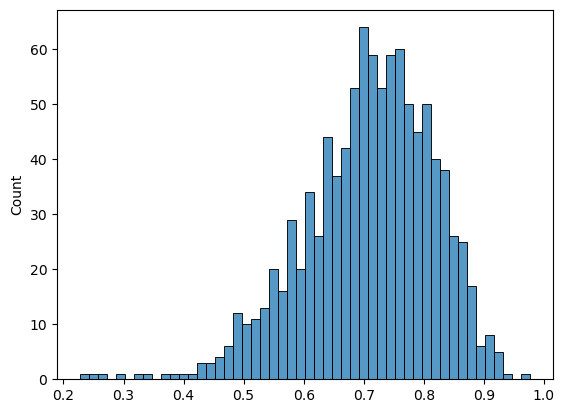

In [51]:
sns.histplot( gibbs_results['trans_mat_draws'][1000:,0,0], bins = 50)

In [6]:
gibbs_results.keys()

dict_keys(['emission_prior', 'emission_weight_draws', 'hidden_states_MLE', 'log_like_draws', 'trans_mat_draws', 'trans_mat_prior'])

In [11]:
gibbs_results['trans_mat_draws'] [50]

Array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32, weak_type=True)

In [26]:
sample_emission_weights(true_hidden_states, obs_data, emission_prior, random.PRNGKey(0) ) . sum (axis=1)

Array([1.0000001, 1.       , 1.       ], dtype=float32)

In [22]:
sample_trans_mat?

Signature: sample_trans_mat(hidden_states, trans_mat_prior, key)
Docstring:
Samples a transition matrix from the conditional distribution given
a sequence of hidden states and a prior over transition matrices.

Args:
    hidden_states: An array of integers of shape `(n_samples,)` representing the
    sequence of hidden states.
    trans_mat_prior: A 2D array of shape `(n_states, n_states)` representing the
    prior over transition matrices. Each row of the matrix is a Dirichlet prior
    over the transitions from a given state.
    key: Optional `jax.random.PRNGKey`. If provided, used for random number generation.

Returns:
    A 2D array of shape `(n_states, n_states)` representing the sampled transition matrix.
File:      ~/Documents/HMMs/src_python/hmm_mcmc.py
Type:      function

In [27]:
sample_trans_mat(true_hidden_states, trans_mat_prior, random.PRNGKey(0))

Array([[0.3893561 , 0.44527414, 0.16536972],
       [0.46679705, 0.29935053, 0.23385243],
       [0.38239956, 0.5524928 , 0.06510768]], dtype=float32)

In [15]:
sample_trans_mat?

Signature: sample_trans_mat(hidden_states, trans_mat_prior, key)
Docstring:
Samples a transition matrix from the conditional distribution given
a sequence of hidden states and a prior over transition matrices.

Args:
    hidden_states: An array of integers of shape `(n_samples,)` representing the
    sequence of hidden states.
    trans_mat_prior: A 2D array of shape `(n_states, n_states)` representing the
    prior over transition matrices. Each row of the matrix is a Dirichlet prior
    over the transitions from a given state.
    key: Optional `jax.random.PRNGKey`. If provided, used for random number generation.

Returns:
    A 2D array of shape `(n_states, n_states)` representing the sampled transition matrix.
File:      ~/Documents/HMMs/src_python/hmm_mcmc.py
Type:      function

In [14]:
key = random.PRNGKey(seed)
prior_params = prior_set(num_states=num_states, single_trans_row_prior=jnp.full(num_states, 1),
                            single_emission_prior=jnp.full(num_bins, 1))
trans_mat_prior = prior_params['trans_mat_prior']
emission_prior = prior_params['emission_prior']
num_obs = len(obs_data)

key, subkey = random.split(key)
hidden_states_init = random.randint(subkey, (num_obs,), 0, num_states)

In [10]:
emission_prior.shape

(4, 3)

In [15]:
def prior_set(num_states, single_trans_row_prior, single_emission_prior):
    """
    Sets prior parameters for binned HMM sampling.
    
    Args:
    - num_states (int): number of hidden states in the HMM.
    - single_trans_row_prior (array): a 1D array of size num_states specifying the prior for each row of the transition matrix.
    - single_emission_prior (array): a 1D array of size num_bins specifying the prior for each emission probability vector. 
    
    Returns:
    - dict: a dictionary containing either trans_mat_prior and emission_prior or mix_weight_prior and emission_prior.
    """
    trans_mat_prior = jnp.tile(single_trans_row_prior, (1,num_states))
    
    emission_prior = jnp.transpose(jnp.tile(single_emission_prior, (1,num_states))) # num_states x num_bins

    return {"trans_mat_prior": trans_mat_prior, "emission_prior": emission_prior}

In [21]:
single_emission_prior=jnp.full(num_bins,1)

In [26]:
jnp.tile(single_emission_prior, (num_states,1) ) . shape

(3, 4)

In [22]:
single_emission_prior

Array([1, 1, 1, 1], dtype=int32, weak_type=True)

In [ ]:
def scan_fun(carry, _):
    key, hidden_states_prev, max_log_like_prev, hidden_states_MLE_prev = carry # Unpack the carry tuple

    key, subkey = random.split(key)
    trans_mat_draw = sample_trans_mat(hidden_states_prev, trans_mat_prior, subkey)

    key, subkey = random.split(key)
    emission_draw = sample_emission_weights(hidden_states_prev, obs_data, emission_prior, subkey)

    key, subkey = random.split(key)
    hidden_states_draw, log_like_draw = sample_hidden_states(obs_data, trans_mat_draw, emission_draw, subkey)

    hidden_states_MLE = jax.lax.cond(jax.lax.gt(log_like_draw,max_log_like_prev),
                                    lambda _: hidden_states_draw,
                                    lambda _: hidden_states_MLE_prev, operand=None)
    max_log_like = jax.lax.cond(jax.lax.gt(log_like_draw, max_log_like_prev),
                                lambda _: log_like_draw,
                                lambda _: max_log_like_prev, operand=None)
    
    return ((key, hidden_states_draw, max_log_like, hidden_states_MLE), (trans_mat_draw, emission_draw, log_like_draw))

key, subkey = random.split(key)
init_carry = (key, hidden_states_init, float('-inf'), hidden_states_init)
(final_carry, draws) = jax.lax.scan(scan_fun, init_carry, jnp.arange(num_its))
_, _, _, hidden_states_MLE = final_carry
trans_mat_draws, emission_draws, log_like_draws = zip(*draws)
